In [1]:
import pandas as pd
import torch
import torch.nn as nn
import scipy.stats as stats
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch.nn.functional as F

# libraries for partitioning and batching the data
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
df = pd.read_csv("default of credit card clients.csv")
data = df.drop('Y', axis=1)
labels = df[['Y']]

In [4]:
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data = torch.tensor(data.values).float()
labels = torch.tensor(labels.values).float()

#X = data
#y = labels

In [5]:
trainsize = 0.75
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=trainsize)
train_dataDataset = TensorDataset(train_data, train_labels)
test_dataDataset = TensorDataset(test_data, test_labels)

In [6]:
batchsize = 8192
# train and test dataloaders
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataDataset,batch_size=batchsize, shuffle=True, drop_last=False)

In [7]:
print(len(train_loader))


3


In [8]:
class ANN(nn.Module):
    def __init__(self, nUnits, nLayers):
        super().__init__()

        # Create a dictionary to store the layers.
        self.layers = nn.ModuleDict()
        self.nLayers = nLayers

        # Input layer.
        self.layers['input'] = nn.Linear(23, nUnits)

        # Hidden layers.
        for i in range(nLayers):
            self.layers[f'hidden{i}'] = nn.Linear(nUnits, nUnits)

        # Output layer.
        self.layers['output'] = nn.Linear(nUnits, 1)

    # Forward pass through the network.
    def forward(self, x):
        x = F.relu(self.layers['input'](x))  # Input layer (with ReLU activation).

        # Hidden layers with ReLU activation.
        for i in range(self.nLayers):
            x = F.relu(self.layers[f'hidden{i}'](x))

        x = self.layers['output'](x)  # Output layer.
        return x


In [9]:
# Define a global parameter 'numepochs' with a value of 500, representing the number of training epochs.
#numepochs = 1000

# Define a function 'trainTheModel' to train the neural network.
def trainTheModel(theModel):
  # loss function
  lossfun = nn.BCEWithLogitsLoss() # but better to use BCEWithLogitsLoss

  # optimizer
  optimizer = torch.optim.SGD(theModel.parameters(),lr=0.1)

  # Initialize lists to store training and test accuracies, as well as losses during training.
  trainAcc = []
  testAcc  = []
  losses   = []

  # Loop over epochs (training iterations).
  for epochi in range(numepochs):
    
    #if epochi % 100 == 0:
    #    print(epochi)
    # Activate training mode for the neural network.
    theModel.train()

    # Initialize lists to store accuracy and loss for each batch during training.
    batchAcc  = []
    batchLoss = []

    # Loop over training data batches.
    for X,y in train_loader:

      # Perform a forward pass through the neural network.
      yHat = theModel(X)
      #print(yHat)
      # Calculate the loss using the specified loss function.
      loss = lossfun(yHat,y)
      
      # Clear previous gradient calculations.
      optimizer.zero_grad()
      
      # Perform backpropagation to compute gradients.
      loss.backward()
      
      # Update the model's parameters using the optimizer.
      optimizer.step()

      # Compute training accuracy for this batch and append to 'batchAcc'.
      #batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchAcc.append( 100*torch.mean(((yHat.round()) == y).float()) )
      
      # Append the loss value for this batch to 'batchLoss'.
      batchLoss.append( loss.item() )
    # End of batch loop...

    # Calculate the average training accuracy for this epoch and append to 'trainAcc'.
    trainAcc.append( np.mean(batchAcc) )

    # Append the average loss for this epoch to 'losses'.
    losses.append( np.mean(batchLoss) )

    # Test accuracy on the validation set.
    
    # Extract X,y from the test dataloader.
    X,y = next(iter(test_loader))

    # Activate evaluation mode (no gradient computation) for the neural network.
    theModel.eval()

    # Perform forward pass for the test data.
    with torch.no_grad():
      #predictions = torch.argmax( ANN(X),axis=1 )
      predictions = theModel(X)
      #print(predictions)
    
    # Compute accuracy on the test data and append to 'testAcc'.
    #testAcc.append( 100*torch.mean((predictions == y).float()).item() )
    testAcc.append( 100*torch.mean(((predictions.round()) == y).float()) )
    #rint(predictions)

    nParams = sum(p.numel() for p in theModel.parameters() if p.requires_grad)
    
  
  # Function output: training accuracies, test accuracies, and losses over epochs.
  return trainAcc, testAcc, losses, nParams

In [10]:
# Define the model parameters: number of layers and number of units per layer.
numlayers = range(1, 4)  # Number of hidden layers.
numunits = np.arange(4, 101, 20)  # Units per hidden layer.


In [19]:
len(numlayers)

3

In [20]:
numlayers

range(1, 4)

In [12]:
len(numunits)

5

In [13]:
numunits

array([ 4, 24, 44, 64, 84])

In [14]:


# Initialize matrices to store accuracies and total parameters.
train_accuracies = np.zeros((len(numunits), len(numlayers)))
test_accuracies = np.zeros((len(numunits), len(numlayers)))
totalparams = np.zeros((len(numunits), len(numlayers)))
losses = np.zeros((len(numunits), len(numlayers)))

# Number of training epochs.
numepochs = 300

# Start the experiment by varying the number of units and layers.
for unitidx in range(len(numunits)):
    for layeridx in range(len(numlayers)):
        print('Unit' + str(unitidx) + " layer " + str(layeridx))
        # Create a fresh model instance.

        net = ANN(numunits[unitidx], numlayers[layeridx])

        # Train the model and store the results.
        trainAcc, testAcc, losses, nParams = trainTheModel(net)
        #acc, nParams = trainTheModel(net)
        #accuracies[unitidx, layeridx] = acc

        train_accuracies[unitidx,layeridx] = np.mean(trainAcc)
        test_accuracies[unitidx,layeridx] = np.mean(testAcc)
        #losses[unitidx,layeridx] = losses

        # Store the total number of parameters in the model.
        totalparams[unitidx, layeridx] = nParams

Unit0 layer 0
Unit0 layer 1
Unit0 layer 2
Unit1 layer 0
Unit1 layer 1
Unit1 layer 2
Unit2 layer 0
Unit2 layer 1
Unit2 layer 2
Unit3 layer 0
Unit3 layer 1
Unit3 layer 2
Unit4 layer 0
Unit4 layer 1
Unit4 layer 2


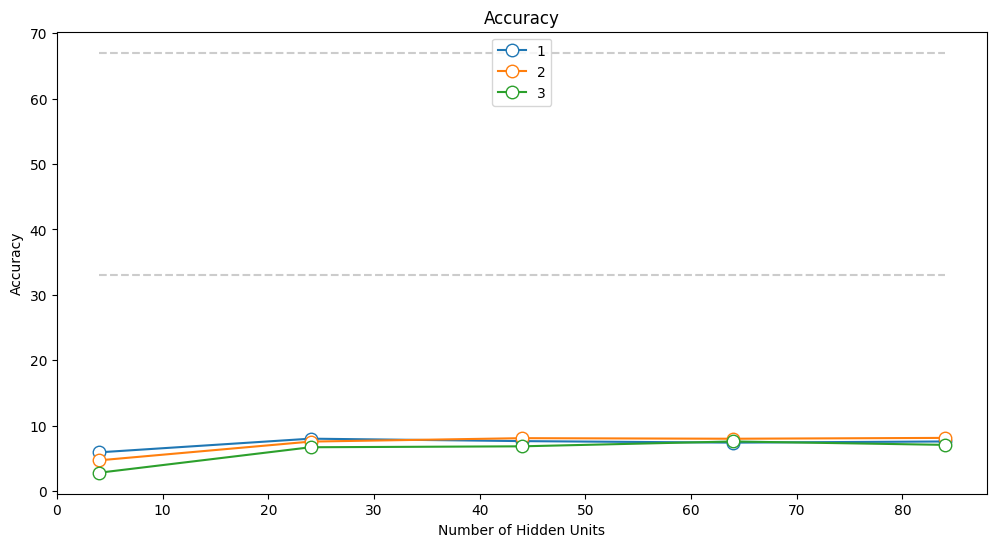

In [16]:
# Show accuracy as a function of the number of hidden units for different layers.
fig, ax = plt.subplots(1, figsize=(12, 6))

ax.plot(numunits, train_accuracies, 'o-', markerfacecolor='w', markersize=9)
ax.plot(numunits[[0, -1]], [33, 33], '--', color=[0.8, 0.8, 0.8])
ax.plot(numunits[[0, -1]], [67, 67], '--', color=[0.8, 0.8, 0.8])
ax.legend(numlayers)
ax.set_ylabel('Train Accuracy')
ax.set_xlabel('Number of Hidden Units')
ax.set_title('Accuracy')
plt.show()


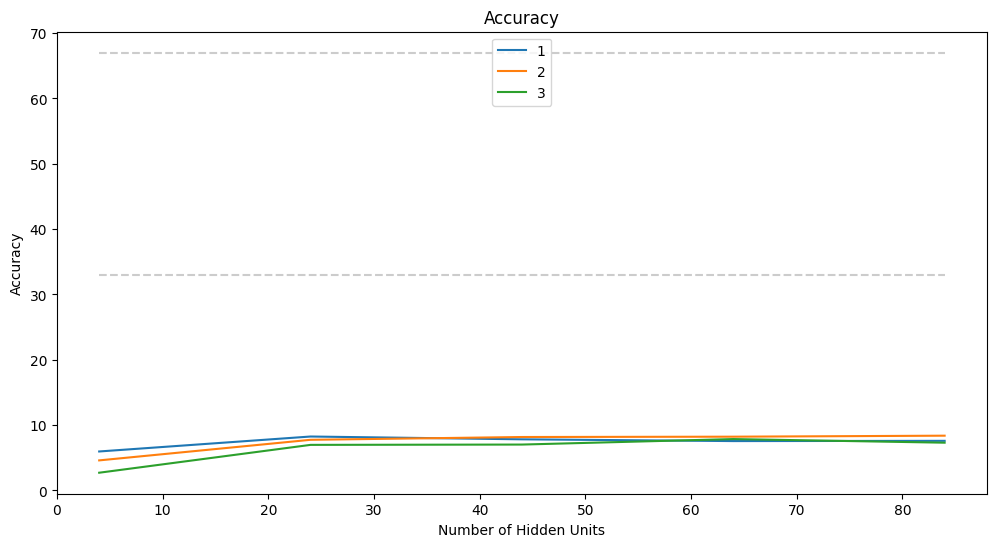

In [17]:
# Show accuracy as a function of the number of hidden units for different layers.
fig, ax = plt.subplots(1, figsize=(12, 6))

ax.plot(numunits, test_accuracies)
ax.plot(numunits[[0, -1]], [33, 33], '--', color=[0.8, 0.8, 0.8])
ax.plot(numunits[[0, -1]], [67, 67], '--', color=[0.8, 0.8, 0.8])
ax.legend(numlayers)
ax.set_ylabel('Test Accuracy')
ax.set_xlabel('Number of Hidden Units')
ax.set_title('Accuracy')
plt.show()

In [18]:
# Analyze the correlation between the number of parameters and accuracy.
x = totalparams.flatten()
y = accuracies.flatten()

# Calculate the correlation coefficient.
r = np.corrcoef(x, y)[0, 1]

# Scatter plot of parameters vs. accuracy.
plt.plot(x, y, 'o')
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy')
plt.title('Correlation: r=' + str(np.round(r, 3)))
plt.show()

NameError: name 'accuracies' is not defined